# Gesture Recognition
- In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.</br>
- We build how to load data and 4 models + pretrained_model to try to solve the problem.</br>
> I. Convolutional 3D</br>
II. Convolutional  + LSTM</br>
III. Convolutional GRU</br>
IV. Pretrain vgg16 + GRU

# Functions, Flasses and Activities
---
>generator(): &nbsp;&nbsp;&nbsp;&nbsp; yield batch of images normalize</br>
get_step(): &nbsp;&nbsp;&nbsp;&nbsp; Create steps_per_epochs and validation_steps</br>
Gesture_Module: &nbsp;&nbsp;&nbsp;&nbsp; Contain all Models</br>
plot_accuracy(): &nbsp;&nbsp;&nbsp;&nbsp; Visualize values of Accuracy training</br>
plot_loss(): &nbsp;&nbsp;&nbsp;&nbsp; Visualize values of Loss</br>
save_model_path(): &nbsp;&nbsp;&nbsp;&nbsp; Create path to save models</br>
callback_lists(): &nbsp;&nbsp;&nbsp;&nbsp; Create callback for Models
---

## Import the Libraries

In [1]:
import numpy as np
import os
import datetime
import os
import random as rn
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from imageio import imread
from skimage.transform import resize

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Flatten,RepeatVector, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3

tf.__version__

'2.9.0'

In [2]:
# Check cuda 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Import the Dataset

Set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
rn.seed(30)
tf.keras.utils.set_random_seed(30)

Set the folder names for training and validation.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

batch_size = 16
num_epochs = 30
image_width = 128
image_height = 128
target_size = (image_width, image_height, 3)

- Create default "steps per epochs" and "validation steps"

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

def get_step(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

steps_per_epoch, validation_steps = get_step(num_train_sequences, num_val_sequences, batch_size)
    
print('# Step per Epochs = ',steps_per_epoch)
print('# Validation steps = ', validation_steps)

# Training sequences = 663
# Validation sequences = 100
# epochs = 30
# Step per Epochs =  42
# Validation steps =  7


## Generator
Using all the imgages in the sequences gives the best results.  But one can skip over every second image in the sequece to reduce the memory footprint by setting:
```
img_idx = [*range(1, 30)]
```
The image dimensions used are 120x120 pixels.  Images that are 160x120 are cropped to 120x120, and images that are 360x360 are resized using a Lanczos filter.  Resizing images by an integer factor minimizes the introduction of resizing artifacts.



In [6]:
# Create sequence leng
img_idx = list(range(0,30))
x=len(img_idx)
            
# Defined  generator function to yield data with 4 type of image normalize
def generator(source_path, folder_list, batch_size, target_size, normalize_type=0):
    '''
        The function yield each of data with shape [batch_size, sequence_len, shape_x, shape_y, channel]
        source_path: str
        folder_list: list, total folders containing videos
        batch_size: int
        target_size: tuple(height, width, channel)
        normalize_type: --->    '0':  divide pixel value by 255 (default)
                                '1':  scale zero center (img-127)/127.
                                '2':  scale distribution percentile
                                '3':  pretrain with vgg processing_input
                           ------------------ ********** -------------------
        
    '''
    print( ' Source path = ', source_path, '; Batch size =', batch_size, '; Target size =', target_size, '; Normalize_type =', normalize_type)
    y, z, _ = target_size
    while True:
        shuf = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        path_inter = 0
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     if image.shape[0] != image.shape[1]:
#                         image = image[0:120, 20:140]
                    image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    if normalize_type == 1:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    elif normalize_type == 2:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] -np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,1] = image[:,:,1] -np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,2] = image[:,:,2] -np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) -np.percentile(image[:,:,0],5))
                    elif normalize_type == 3:
                        image = tf.keras.applications.vgg16.preprocess_input(image, data_format=None)
                        batch_data[folder,idx,:,:,:] = image
                    else:
                        batch_data[folder,idx,:,:,:] = image/255.
                    
                batch_labels[folder, int(shuf[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            path_inter = batch
            yield batch_data, batch_labels        
        
        folders_not_process = len(folder_list)-num_batches*batch_size
        if folders_not_process !=0:   # Process the Residual after appling batch_size : E.g total_video = 663, batch=16 . residual = 663-(663//16)*16 = 7
            path_inter+=1             # Continues at shuffle total_video[path_inter]. Created above
            batch_data = np.zeros((folders_not_process,x,y,z,3))
            batch_labels = np.zeros((folders_not_process,5))

            for folder in range(folders_not_process):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (path_inter*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (path_inter*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     if image.shape[0] != image.shape[1]:
#                         image = image[0:120, 20:140]
                    image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    if normalize_type == 1:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    elif normalize_type == 2:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] -np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,1] = image[:,:,1] -np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) -np.percentile(image[:,:,0],5))
                        batch_data[folder,idx,:,:,2] = image[:,:,2] -np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) -np.percentile(image[:,:,0],5))
                    elif normalize_type == 3:
                        image = tf.keras.applications.vgg16.preprocess_input(image, data_format=None)
                        batch_data[folder,idx,:,:,:] = image
                    else:
                        batch_data[folder,idx,:,:,:] = image/255.
                    
                batch_labels[folder, int(shuf[folder + (path_inter*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

## Model Definitions


In [7]:
# Defined class contain all of model and pretrain model
# Convenient for calling model
class Gesture_Module:
    def __init__(self, input_shape, no_class):
        self.input_shape = input_shape
        self.no_class = no_class
        
    def cnnGRU_v1(self):
        model = Sequential(name='cnn_gru_01')

        model.add(TimeDistributed(Conv2D(8,(3,3),strides=(2,2), activation='relu'), input_shape=self.input_shape))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(16,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(16,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(16,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Flatten()))
        model.add(GRU(128, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

    
    def cnnGRU_v2(self):
        model = Sequential(name='cnn_gru_02')

        model.add(TimeDistributed(Conv2D(8,(5,5),strides=(2,2), activation='relu'), input_shape=self.input_shape))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Flatten()))
        model.add(GRU(128, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_class, activation='softmax'))
        return model
    
    def cnnGRU_v3(self):
        model = Sequential(name='cnn_gru_03')

        model.add(TimeDistributed(Conv2D(8,(5,5),strides=(2,2), activation='relu'), input_shape=self.input_shape))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(5,5), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(128, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

Configure and instantiate the model class

## Plotting Functions
## Create Path Functions
## Create Callbacks Functions

In [8]:
# Function to plot the model accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Function to plot the model loss
def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# Model storage path constructor
def save_model_path(model_name):
    model_name = 'output/'+model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.makedirs(model_name)
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    return filepath

# initialize Callbacks function 
def callback_lists(filepath, monitor='val_loss', factor=0.1, patience=3, mode='auto', min_lr=1e-5, epsilon=0.0001):
    print('# filepath: ', filepath)
    print('# min_lr: ', min_lr)
    print('# monitor: ', monitor)
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, epsilon=epsilon,  save_weights_only=False, mode=mode, period=1)
    LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,
                                             factor=factor,
                                             patience=patience,
                                             mode=mode,
                                             min_lr=min_lr)
    return  [checkpoint, LR]

In [9]:
# Number of classification classes
no_class = 5 # [Thumbs up, Thumbs down, Left swipe, Right swipe, secondsStop]
batch_size = 16
# Input shape (sequence_len, shapeY, shapeX, channel)
input_shape = (len(img_idx), image_height, image_width, 3)
# Instantiate the model class
GestureNet = Gesture_Module(input_shape, no_class)

# <center>TRAINING MODELS</center> #

# Pretrained CNNGRU_01

In [10]:
cnnGRU_1 = GestureNet.cnnGRU_v1()

batch_size = 16
steps_per_epoch, validation_steps = get_step(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=1)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=1)

filepath = save_model_path(cnnGRU_1.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
cnnGRU_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(cnnGRU_1.summary())

# filepath:  output/cnn_lstm_01_2022-11-1616_36_15.536772/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn_lstm_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 63, 63, 8)    224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 31, 31, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 29, 29, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 14, 14, 16)

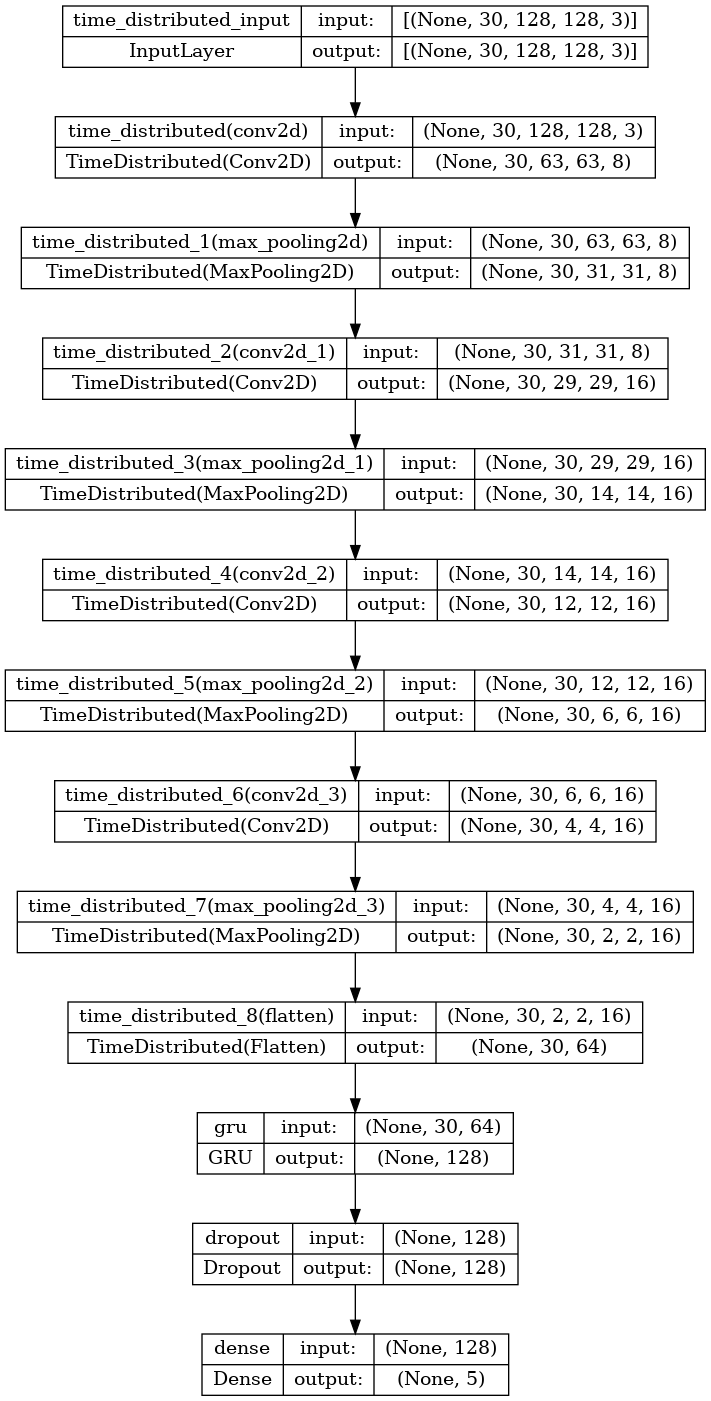

In [11]:
# Plot a diagram of the model
tf.keras.utils.plot_model(cnnGRU_1, "cnngru_1.png", show_shapes=True)

In [12]:
# Train the model for 30 epochs
num_epochs = 30
cnnGRU_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator, 
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1


<ipython-input-12-bef03c9b4086>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnnGRU_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.5611 - categorical_accuracy: 0.2624 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1

Epoch 1: val_loss improved from inf to 1.46316, saving model to output/cnn_lstm_01_2022-11-1616_36_15.536772/model-00001-1.56115-0.26244-1.46316-0.37000.h5
42/42 [==============================] - 41s 930ms/step - loss: 1.5611 - categorical_accuracy: 0.2624 - val_loss: 1.4632 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.4179 - categorical_accuracy: 0.3741
Epoch 2: val_loss improved from 1.46316 to 1.42847, saving model to output/cnn_lstm_01_2022-11-1616_36_15.536772/model-00002-1.41793-0.37406-1.42847-0.34000.h5
42/42 [==============================] - 38s 932ms/step - loss: 1.4179 - categorical_accuracy: 0.3741 - val_loss: 1.4285 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/30
42/42 [==============

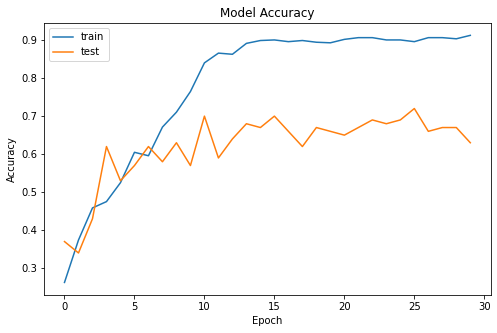

In [13]:
# Plot the model accuracy
plot_accuracy(cnnGRU_1.history)

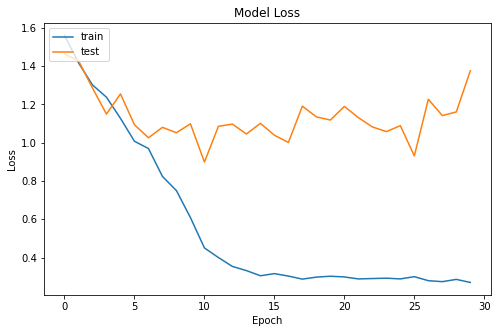

In [14]:
# Plot the model loss
plot_loss(cnnGRU_1.history)

# Pretrained CNNGRU_02

In [15]:
cnnGRU_2 = GestureNet.cnnGRU_v2()

batch_size = 32
steps_per_epoch, validation_steps = get_step(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=3)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=3)

filepath = save_model_path(cnnGRU_2.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
cnnGRU_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(cnnGRU_2.summary())

# filepath:  output/cnn_lstm_02_2022-11-1616_36_15.536772/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn_lstm_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 30, 62, 62, 8)    608       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 31, 31, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 27, 27, 32)   6432      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 13, 13, 32)

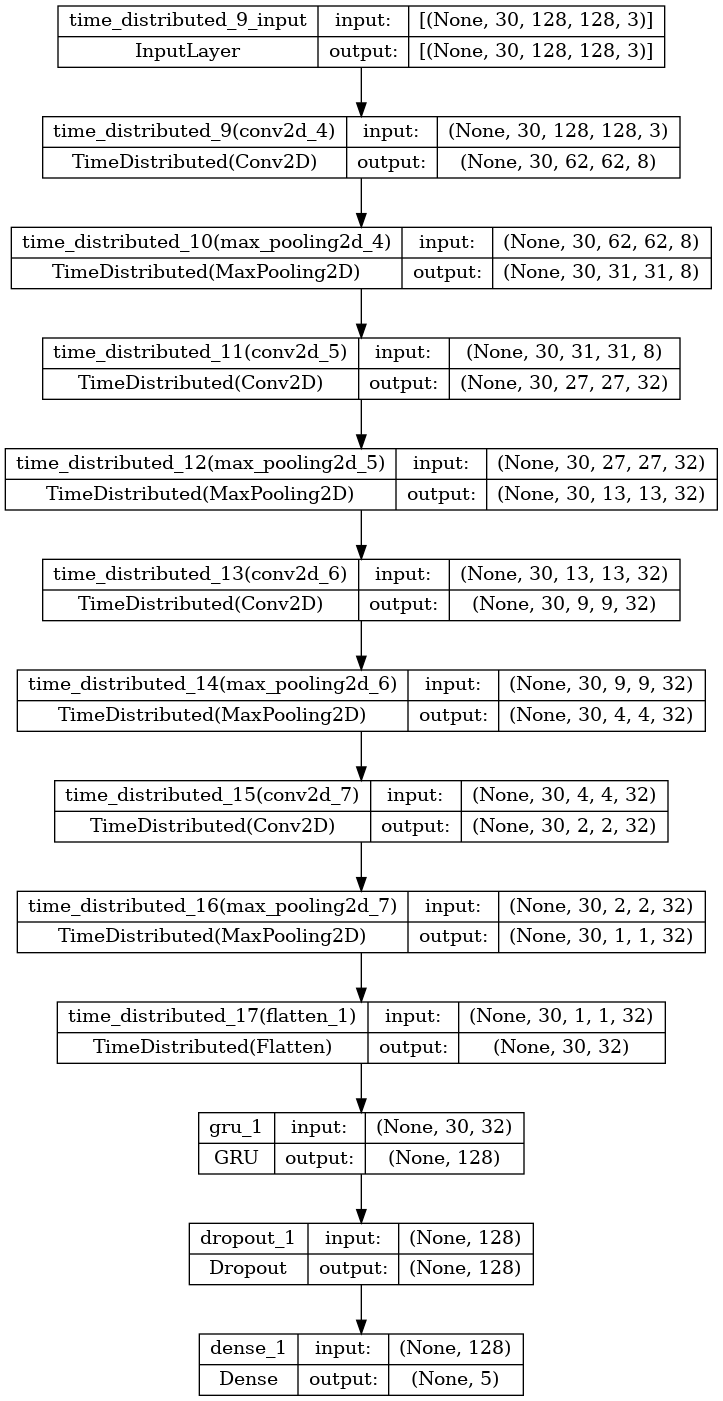

In [16]:
# Plot a diagram of the model
tf.keras.utils.plot_model(cnnGRU_2, "cnngru_2.png", show_shapes=True)

In [17]:
# Train the model for 30 epochs
num_epochs = 30
cnnGRU_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator, 
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-17-bb588755c9e2>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnnGRU_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


 Source path =  Project_data/train ; Batch size = 32 ; Target size = (128, 128, 3) ; Normalize_type = 3
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.0622 - categorical_accuracy: 0.2142 Source path =  Project_data/val ; Batch size = 32 ; Target size = (128, 128, 3) ; Normalize_type = 3

Epoch 1: val_loss improved from inf to 1.59371, saving model to output/cnn_lstm_02_2022-11-1616_36_15.536772/model-00001-2.06216-0.21418-1.59371-0.20000.h5
21/21 [==============================] - 41s 2s/step - loss: 2.0622 - categorical_accuracy: 0.2142 - val_loss: 1.5937 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.9532 - categorical_accuracy: 0.2142
Epoch 2: val_loss did not improve from 1.59371
21/21 [==============================] - 39s 2s/step - loss: 1.9532 - categorical_accuracy: 0.2142 - val_loss: 1.6341 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
21/21 [=============================

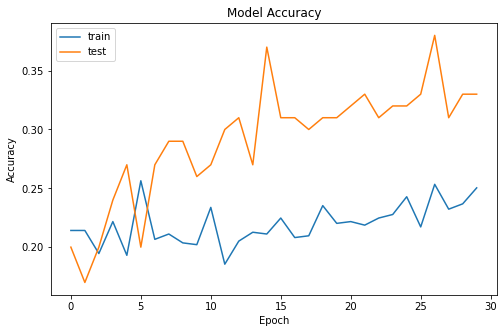

In [18]:
# Plot the model accuracy
plot_accuracy(cnnGRU_2.history)

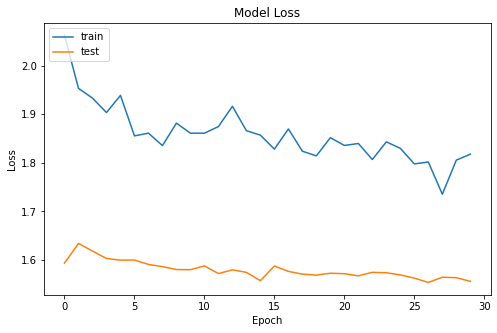

In [19]:
# Plot the model loss
plot_loss(cnnGRU_2.history)

## Pretrained CNNGRU_03

In [20]:
# Call cnnGRU_gru() model, Modify batch_size and steps_per_epoch, validation_steps
cnnGRU_3 = GestureNet.cnnGRU_v3()

batch_size = 16
steps_per_epoch, validation_steps = get_step(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, target_size, normalize_type=1)
val_generator = generator(val_path, val_doc, batch_size, target_size, normalize_type=1)

filepath = save_model_path(cnnGRU_3.name)
callbacks_list = callback_lists(filepath)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
cnnGRU_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(cnnGRU_3.summary())

# filepath:  output/cnn_lstm_03_2022-11-1616_36_15.536772/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5
# min_lr:  1e-05
# monitor:  val_loss
Model: "cnn_lstm_03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 30, 62, 62, 8)    608       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 31, 31, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 27, 27, 32)   6432      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 13, 13, 32)

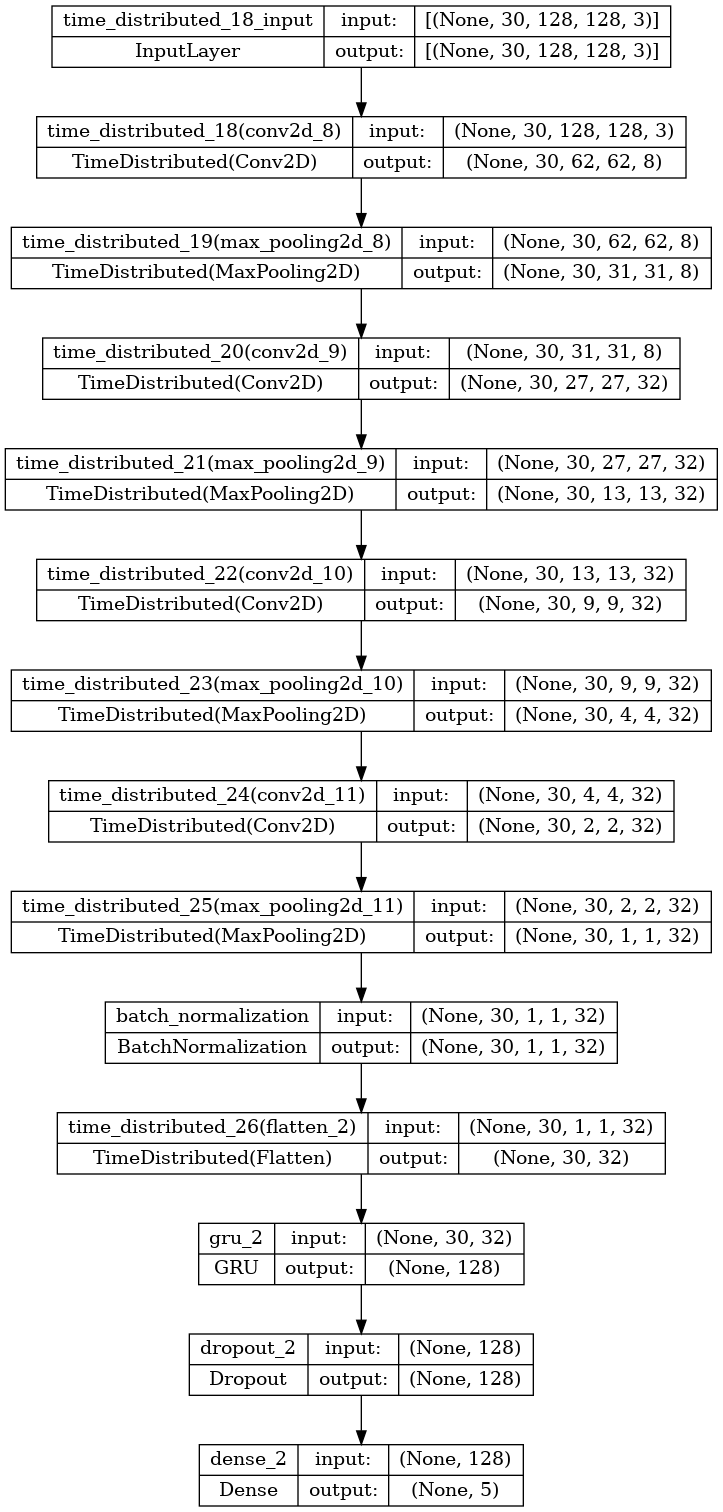

In [21]:
# Plot a diagram of the model
tf.keras.utils.plot_model(cnnGRU_3, "cnngru_3.png", show_shapes=True)

In [22]:
# Train the model for 30 epochs
num_epochs = 30
cnnGRU_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator, 
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-22-b7cc27608785>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnnGRU_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


 Source path =  Project_data/train ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.3742 - categorical_accuracy: 0.3982 Source path =  Project_data/val ; Batch size = 16 ; Target size = (128, 128, 3) ; Normalize_type = 1

Epoch 1: val_loss improved from inf to 1.76524, saving model to output/cnn_lstm_03_2022-11-1616_36_15.536772/model-00001-1.37422-0.39819-1.76524-0.23000.h5
42/42 [==============================] - 42s 973ms/step - loss: 1.3742 - categorical_accuracy: 0.3982 - val_loss: 1.7652 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.1732 - categorical_accuracy: 0.5189
Epoch 2: val_loss improved from 1.76524 to 1.70486, saving model to output/cnn_lstm_03_2022-11-1616_36_15.536772/model-00002-1.17317-0.51885-1.70486-0.30000.h5
42/42 [==============================] - 38s 922ms/step - loss: 1.1732 - categorical_accuracy: 0.

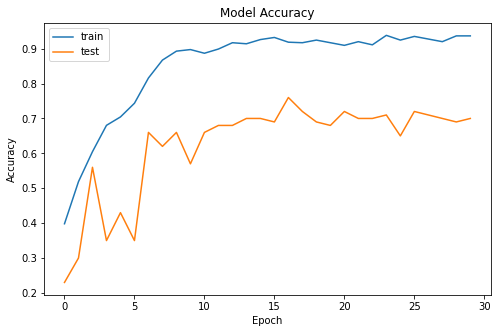

In [23]:
# Plot the model accuracy
plot_accuracy(cnnGRU_3.history)

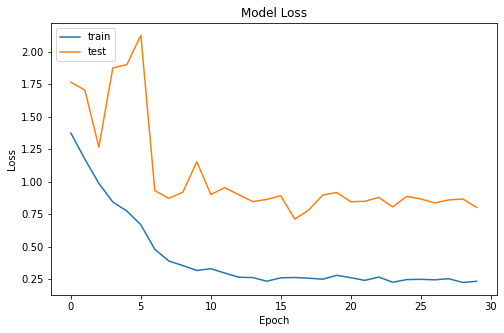

In [24]:
# Plot the model loss
plot_loss(cnnGRU_3.history)